In [697]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('seaborn-whitegrid')
import seaborn as sb
import datetime as dt
import timeit

In [670]:
dfData = pd.read_csv("dfData.csv")
dfData.set_index('time_period', inplace = True)
dfData.fillna(value = 0, inplace=True)
print(len(dfData))
dfData.head(20)

588


,volume_traded,Bullish,Positive,Negative,Hopeful,Euphoric/Excited,Long_term_investing,price_open,trades_count,Selling,...,Optimistic,price_high,rsi,bolinger_high,bolinger_low,bolinger_middle,macd,vortex,stoch,movement
time_period,,,,,,,,,,,,,,,,,,,,,
12/28/2020,25763.51754,89,166,122,12,27,79,684.42,15333,35,...,44,746.98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
12/29/2020,16248.29869,56,144,133,10,13,53,729.02,11362,26,...,35,739.09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.445256e+05
12/30/2020,14385.47579,66,101,53,7,19,36,731.79,9679,16,...,26,758.60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.050903e+07
12/31/2020,18938.33743,48,112,89,12,20,39,752.50,9639,11,...,35,756.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.680988e+06
01/01/2021,15129.68596,24,83,74,3,16,28,736.90,7544,12,...,28,750.39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.011855e+06
01/02/2021,26362.64832,75,129,106,10,24,45,731.19,13326,19,...,34,788.89,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.092775e+07
01/03/2021,86710.73835,169,325,191,27,88,104,775.24,38600,58,...,42,1021.85,94.762168,860.170556,692.180873,776.175714,0.000000,0.000000,87.299865,9.340068e+07
01/04/2021,88682.01485,120,261,212,9,59,100,980.02,50719,42,...,55,1168.00,95.899571,942.758774,699.075511,820.917143,0.000000,0.456131,73.811308,7.302116e+07
01/05/2021,48366.89405,105,205,177,11,46,58,1043.99,32159,19,...,58,1135.42,96.695249,1023.060747,724.999253,874.030000,0.000000,0.551201,85.744848,1.357327e+07


In [671]:
prediction_days = 35 #five weeks in advance (first week will be shifted in test)
df_train = dfData[:len(dfData)-prediction_days+7]# adding one week since in test input will be shifted
df_test = dfData[len(dfData)-prediction_days:]  

In [672]:
print(len(df_train))
print(len(df_test))

560
35


In [673]:
# Data preprocess
training_set = df_train.to_numpy()
print(len(training_set))
dfData.dtypes

560


volume_traded          float64
Bullish                  int64
Positive                 int64
Negative                 int64
Hopeful                  int64
Euphoric/Excited         int64
Long_term_investing      int64
price_open             float64
trades_count             int64
Selling                  int64
price_low              float64
Buying                   int64
price_close            float64
Optimistic               int64
price_high             float64
rsi                    float64
bolinger_high          float64
bolinger_low           float64
bolinger_middle        float64
macd                   float64
vortex                 float64
stoch                  float64
movement               float64
dtype: object

In [674]:
def create_train_test_list(df_train, df_test, target, window):
    target_index = df_train.columns.get_loc(target)
    num_cols = len(df_train.columns)
    trainList = []
    testList = []
    
    for index in range(num_cols):
        inputs = []
        for i in range(0, df_train.shape[0]-window):
            if index == target_index:
                inputs.append(df_train.iloc[i+window, index])
            else:
                inputs.append(df_train.iloc[i:i+window, index])
        trainList.append(inputs)
        
    for index in range(num_cols):
        inputs = []
        for i in range(0, df_test.shape[0]-window):
            if index == target_index:
                inputs.append(df_test.iloc[i+window, index])
            else:
                inputs.append(df_test.iloc[i:i+window, index])
        testList.append(inputs)        
    
    return trainList, testList

In [675]:
target = "price_close"
trainList, testList = create_train_test_list(df_train, df_test, target, 7)

In [676]:
target_index = df_train.columns.get_loc(target)
y_train = trainList[target_index]
y_train = np.reshape(y_train, (len(y_train), 1))
y_test = testList[target_index]
y_test = np.reshape(y_test, (len(y_test), 1))

trainList[target_index] = y_train
testList[target_index] = y_test

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

for i in range(len(trainList)):
    if i == target_index:
        trainList[i] = scaler_y.fit_transform(trainList[i])
    else:
        trainList[i] = scaler_x.fit_transform(trainList[i])
        

for i in range(len(testList)):
    if i == target_index:
        testList[i] = scaler_y.fit_transform(testList[i])
    else:
        testList[i] = scaler_x.fit_transform(testList[i])
    
y_train = trainList[target_index]
y_test = testList[target_index]

print(y_train.shape)
print(y_test.shape)

(553, 1)
(28, 1)


In [677]:
del trainList[target_index]
del testList[target_index]

In [678]:
x_train = np.stack(trainList, axis=2)
x_test = np.stack(testList, axis=2)

In [679]:
print(x_train.shape)
print(x_test.shape)

(553, 7, 22)
(28, 7, 22)


# Final Model

In [693]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(units=350, activation="relu", return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])),
  tf.keras.layers.Dense(40, activation="relu"),
  tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_149 (LSTM)              (None, 350)               522200    
_________________________________________________________________
dense_296 (Dense)            (None, 40)                14040     
_________________________________________________________________
dense_297 (Dense)            (None, 1)                 41        
Total params: 536,281
Trainable params: 536,281
Non-trainable params: 0
_________________________________________________________________


In [694]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics="mae")

In [695]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=5,
                                                    restore_best_weights=True)

In [698]:
start = timeit.default_timer()
model.fit(x_train,y_train, epochs=50, batch_size=2, callbacks=[early_stopping])
stop = timeit.default_timer()
print('Time: ', stop - start)  

Epoch 1/50
277/277 [==============================] - 10s 20ms/step - loss: 0.0068 - mae: 0.0608
Epoch 2/50
277/277 [==============================] - 5s 20ms/step - loss: 0.0034 - mae: 0.0459
Epoch 3/50
277/277 [==============================] - 6s 20ms/step - loss: 0.0023 - mae: 0.0362
Epoch 4/50
277/277 [==============================] - 6s 20ms/step - loss: 0.0022 - mae: 0.0355: 0s - loss: 0.0022 - mae: 0.035
Epoch 5/50
277/277 [==============================] - 6s 20ms/step - loss: 0.0028 - mae: 0.0409
Epoch 6/50
277/277 [==============================] - 6s 20ms/step - loss: 0.0022 - mae: 0.0357
Epoch 7/50
277/277 [==============================] - 5s 20ms/step - loss: 0.0019 - mae: 0.0330
Epoch 8/50
277/277 [==============================] - 6s 20ms/step - loss: 0.0020 - mae: 0.0319
Epoch 9/50
277/277 [==============================] - 6s 20ms/step - loss: 0.0022 - mae: 0.0360: 0s - loss: 0.0020
Epoch 10/50
277/277 [==============================] - 6s 20ms/step - loss: 0.0017 -

In [699]:
predictions = model.predict(x_test)
unscalledPredictions = predictions.tolist()
unscalledPredictions = scaler_y.inverse_transform(unscalledPredictions)

In [700]:
unscalledPredictions

array([[1082.33618182],
       [1058.12195358],
       [1054.91338861],
       [1075.57613584],
       [1142.28985728],
       [1164.86849206],
       [1197.22817411],
       [1232.17230732],
       [1384.63963462],
       [1472.82010361],
       [1517.64903546],
       [1502.51891679],
       [1526.21327481],
       [1504.307149  ],
       [1598.35407131],
       [1481.52401148],
       [1450.08609174],
       [1532.09126995],
       [1691.37981332],
       [1668.00483457],
       [1659.21205051],
       [1658.72896072],
       [1629.47048675],
       [1673.31082208],
       [1637.3337584 ],
       [1595.09852784],
       [1689.95950269],
       [1680.08791256]])

In [701]:
unscalledTest = y_test.tolist()
unscalledTest = scaler_y.inverse_transform(unscalledTest)
unscalledTest

array([[1095.55],
       [1037.51],
       [1114.67],
       [1192.6 ],
       [1230.89],
       [1355.44],
       [1338.12],
       [1580.67],
       [1542.41],
       [1521.91],
       [1575.49],
       [1535.43],
       [1548.89],
       [1597.99],
       [1441.61],
       [1448.73],
       [1636.54],
       [1724.91],
       [1722.54],
       [1697.3 ],
       [1678.95],
       [1630.73],
       [1631.03],
       [1618.62],
       [1608.23],
       [1736.57],
       [1690.33],
       [1700.39]])

In [702]:
metrics.max_error(unscalledTest, unscalledPredictions)

348.4976926791669

In [703]:
metrics.mean_absolute_error(unscalledTest, unscalledPredictions)

82.77287272603255

In [716]:
metrics.r2_score(unscalledTest, unscalledPredictions)

0.6800256104079136

In [717]:
metrics.median_absolute_error(unscalledTest, unscalledPredictions)

51.89035923540587

In [704]:
startDate = dt.datetime(2022, 7, 11)
endDate = startDate + dt.timedelta(days=28)

days = mdates.drange(startDate,endDate,dt.timedelta(days=1))

len(days)

28

In [705]:
y_pred = np.reshape(unscalledPredictions, 28).tolist()
y = np.reshape(unscalledTest, 28).tolist()

In [706]:
base = dt.datetime(2022, 8, 7)
date_list = [base - dt.timedelta(days=x) for x in range(28)]
date_list.reverse()

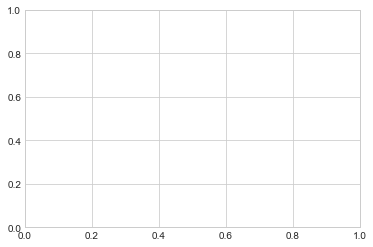

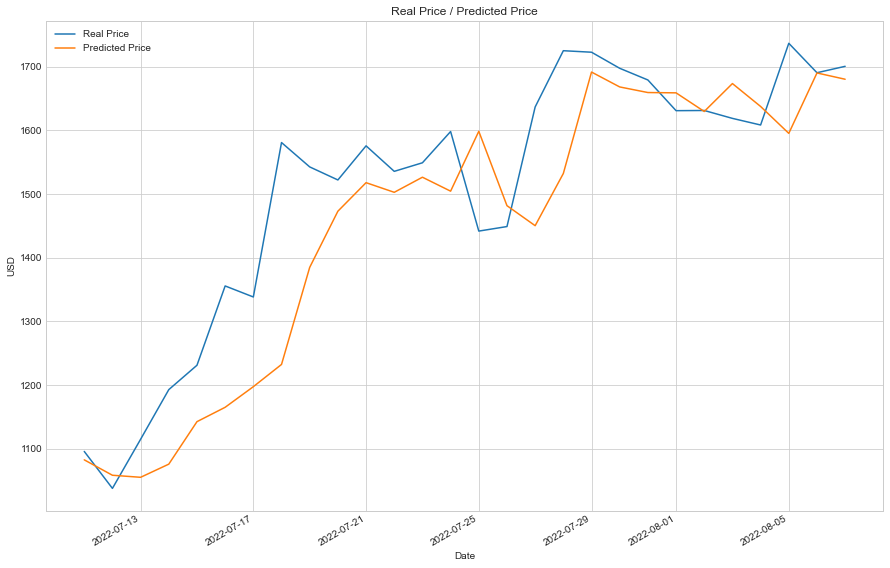

In [707]:
fig = plt.figure()
ax = plt.axes()
plt.subplots(figsize=(15,10))
plt.title("Real Price / Predicted Price")
plt.xlabel("Date")
plt.ylabel("USD")
plt.plot(date_list, y, label="Real Price")
plt.plot(date_list, y_pred, label="Predicted Price")
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig('LTSMfinalPrediction.jpg')

# Tunning

In [490]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=5
                                                    )    
for ltsmNeurons in range(300, 360, 10):
    for denseNeurons in range(32,46,4):
        model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(ltsmNeurons, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])),
        tf.keras.layers.Dense(denseNeurons, activation="relu"),
        tf.keras.layers.Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam', metrics='mae')
        model.fit(x_train,y_train, epochs=50, batch_size=2, callbacks=[early_stopping], verbose=False)
        predictions = model.predict(x_test)
        unscalledPredictions = predictions.tolist()
        unscalledPredictions = scaler_y.inverse_transform(unscalledPredictions)
        mae = metrics.max_error(unscalledTest, unscalledPredictions)
        maxError = metrics.mean_absolute_error(unscalledTest, unscalledPredictions)
        print("METRICS FOR LTSM {} units and Dense {} units. MAE: {:.3f}, MAX: {:.3f}".format(ltsmNeurons, denseNeurons, mae, maxError))


METRICS FOR LTSM 300 units and Dense 32 units. MAE: 380.647, MAX: 106.204
METRICS FOR LTSM 300 units and Dense 36 units. MAE: 399.914, MAX: 113.663
METRICS FOR LTSM 300 units and Dense 40 units. MAE: 355.099, MAX: 86.212
METRICS FOR LTSM 300 units and Dense 44 units. MAE: 382.334, MAX: 88.810
METRICS FOR LTSM 310 units and Dense 32 units. MAE: 384.698, MAX: 103.801
METRICS FOR LTSM 310 units and Dense 36 units. MAE: 383.343, MAX: 96.201
METRICS FOR LTSM 310 units and Dense 40 units. MAE: 398.718, MAX: 115.347
METRICS FOR LTSM 310 units and Dense 44 units. MAE: 377.412, MAX: 105.532
METRICS FOR LTSM 320 units and Dense 32 units. MAE: 398.778, MAX: 118.450
METRICS FOR LTSM 320 units and Dense 36 units. MAE: 344.263, MAX: 79.605
METRICS FOR LTSM 320 units and Dense 40 units. MAE: 384.947, MAX: 102.230
METRICS FOR LTSM 320 units and Dense 44 units. MAE: 355.056, MAX: 94.162
METRICS FOR LTSM 330 units and Dense 32 units. MAE: 384.411, MAX: 98.642
METRICS FOR LTSM 330 units and Dense 36 unit

# Initial

In [477]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(units=320, return_sequences = False, input_shape=(x_train.shape[1], x_train.shape[2])),
  tf.keras.layers.Dense(40, activation="relu"),
  tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 320)               439040    
_________________________________________________________________
dense_196 (Dense)            (None, 40)                12840     
_________________________________________________________________
dense_197 (Dense)            (None, 1)                 41        
Total params: 451,921
Trainable params: 451,921
Non-trainable params: 0
_________________________________________________________________


In [478]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics="mean_absolute_error")

In [479]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=5
                                                    )

In [480]:
model.fit(x_train,y_train, epochs=50, batch_size=2, callbacks=[early_stopping])

Epoch 1/50
277/277 [==============================] - 5s 10ms/step - loss: 0.0095 - mean_absolute_error: 0.0633
Epoch 2/50
277/277 [==============================] - 3s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0410
Epoch 3/50
277/277 [==============================] - 3s 10ms/step - loss: 0.0027 - mean_absolute_error: 0.0407
Epoch 4/50
277/277 [==============================] - 3s 10ms/step - loss: 0.0025 - mean_absolute_error: 0.0381
Epoch 5/50
277/277 [==============================] - 3s 10ms/step - loss: 0.0026 - mean_absolute_error: 0.0386
Epoch 6/50
277/277 [==============================] - 3s 10ms/step - loss: 0.0024 - mean_absolute_error: 0.0375
Epoch 7/50
277/277 [==============================] - 3s 10ms/step - loss: 0.0020 - mean_absolute_error: 0.0338
Epoch 8/50
277/277 [==============================] - 3s 10ms/step - loss: 0.0020 - mean_absolute_error: 0.0336
Epoch 9/50
277/277 [==============================] - 3s 10ms/step - loss: 0.0021 - mean_absolute_error:

In [481]:
predictions = model.predict(x_test)
unscalledPredictions = predictions.tolist()
unscalledPredictions = scaler_y.inverse_transform(unscalledPredictions)

In [482]:
unscalledTest = y_test.tolist()
unscalledTest = scaler_y.inverse_transform(unscalledTest)

In [483]:
metrics.max_error(unscalledTest, unscalledPredictions)

353.2005679684878

In [484]:
metrics.mean_absolute_error(unscalledTest, unscalledPredictions)

97.813162180796

In [485]:
y_pred = np.reshape(unscalledPredictions, 28).tolist()
y = np.reshape(unscalledTest, 28).tolist()

In [486]:
base = dt.datetime(2022, 8, 7)
date_list = [base - dt.timedelta(days=x) for x in range(28)]
date_list.reverse()

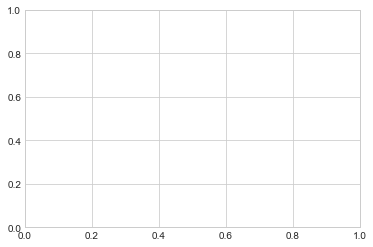

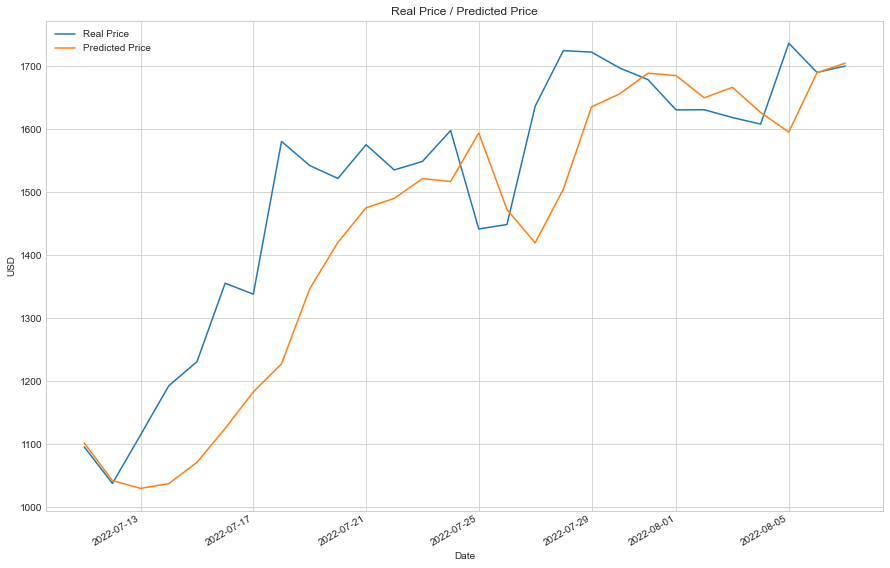

In [487]:
fig = plt.figure()
ax = plt.axes()
plt.subplots(figsize=(15,10))
plt.title("Real Price / Predicted Price")
plt.xlabel("Date")
plt.ylabel("USD")
plt.plot(date_list, y, label="Real Price")
plt.plot(date_list, y_pred, label="Predicted Price")
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig('LTSMinitialPrediction.jpg')

In [708]:
gbrPred = pd.read_csv("GBRpredictions.csv")

In [713]:
y_gbr = []
for item in gbrPred["0"]:
    y_gbr.append(item)

In [710]:
y_pred

[1082.336181819439,
 1058.1219535810128,
 1054.9133886072038,
 1075.576135835126,
 1142.289857276678,
 1164.8684920632838,
 1197.2281741058825,
 1232.1723073208332,
 1384.6396346187591,
 1472.8201036059857,
 1517.649035462141,
 1502.5189167892931,
 1526.2132748055458,
 1504.3071489977835,
 1598.3540713095665,
 1481.5240114808082,
 1450.0860917448997,
 1532.0912699508667,
 1691.3798133206367,
 1668.0048345685004,
 1659.2120505070686,
 1658.7289607238768,
 1629.4704867529867,
 1673.3108220767974,
 1637.333758404255,
 1595.098527843952,
 1689.9595026910304,
 1680.0879125595093]

In [714]:
y_gbr

[1146.5120277905507,
 1045.220237795289,
 1042.3933897391285,
 1110.3151916792938,
 1187.6768307093464,
 1248.619139442523,
 1249.9247390181094,
 1378.2012272726067,
 1598.9449556891682,
 1523.3132302927895,
 1570.7607376599185,
 1554.3481476964907,
 1543.2681313939013,
 1512.5871957376305,
 1647.9227256916113,
 1421.8270875112476,
 1438.7513935086092,
 1596.6960101098455,
 1740.6494140917864,
 1690.0717321146567,
 1773.9496438803862,
 1664.6818729406946,
 1639.2726808709106,
 1603.7018450561193,
 1637.9204757006487,
 1623.295341435199,
 1721.8713026078274,
 1717.5218119454394]

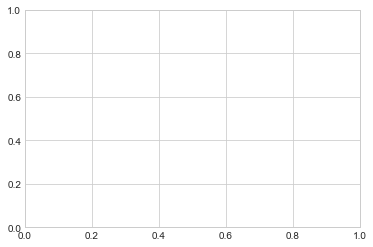

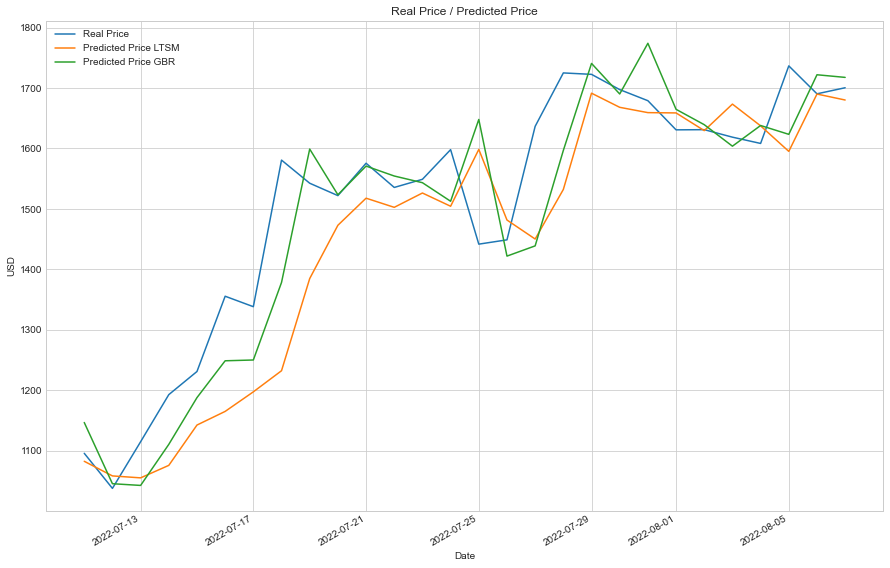

In [715]:
fig = plt.figure()
ax = plt.axes()
plt.subplots(figsize=(15,10))
plt.title("Real Price / Predicted Price")
plt.xlabel("Date")
plt.ylabel("USD")
plt.plot(date_list, y, label="Real Price")
plt.plot(date_list, y_pred, label="Predicted Price LTSM")
plt.plot(date_list, y_gbr, label="Predicted Price GBR")
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig('ComparisonPrediction.jpg')